# Bayesian A/B Testing

In [2]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Ref.: **C. Davidson-Pilon, Bayesian methods for hackers, 2015**

**Problem:**
Front-end web developers are interested in which design of their website yields more sales or some other metric of interest create a dataset; they will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded in real-time, and analyzed afterwards.



In [3]:
import pymc3 as pm
from scipy import stats 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# generate our dataset 

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size = N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size = N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] ...


**Goal**: in comparing design A with design B, we want to determine if one of the two is significantly better than the other. 

Let's set up a odel with pymc


In [5]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model_all:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    step = pm.Metropolis() #we will see more next week
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:] #<----- select after burn-in of 1000 samples

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [6]:
# compute posteriors on inferred parameters
post_p_A = burned_trace["p_A"]
post_p_B = burned_trace["p_B"]
post_delta = burned_trace["delta"]

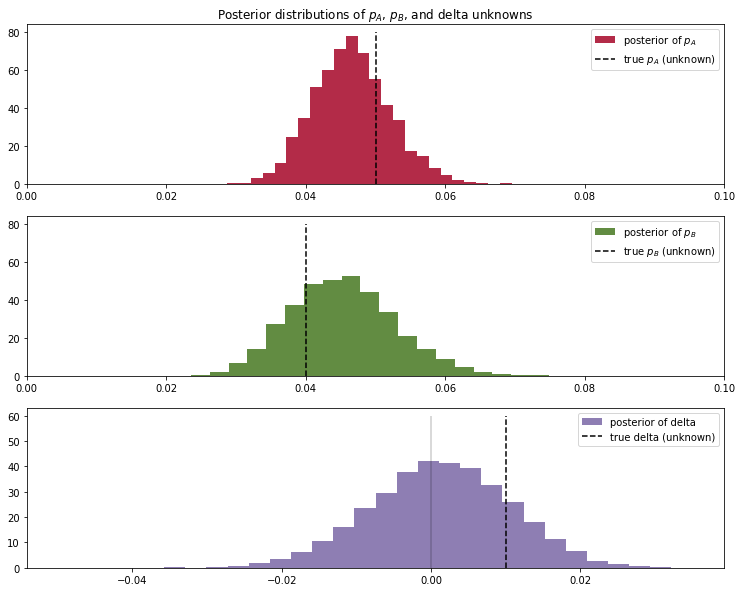

In [7]:
plt.figure(figsize=(12.5, 10))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(post_p_A, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(post_p_B, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(post_delta, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right")

## Metrics

In [40]:
# probability that site A is worse than B
print("probability that site A is worse than B: ", np.mean(post_delta<0))
# probability that site A is better than B
print("probability that site A is better than B: ", np.mean(post_delta>0))


probability that site A is worse than B:  0.44144736842105264
probability that site A is better than B:  0.5585526315789474


In [41]:
#treatment lift
print("treatment lift: ", np.mean((post_p_B-post_p_A)/post_p_A))


treatment lift:  -0.01232126175807949


In [44]:
#loss
print("loss: ", np.mean(np.max(post_p_B-post_p_A,0)))

loss:  0.049904685151315624
